<a href="https://colab.research.google.com/github/susie682/Infosys722--Assignment-4-BDAS/blob/main/8_5_iterations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 8.5 — Iterations (Colab)

This notebook reproduces **Table 8** and **Figures 83–84** for the report.

**What it does**
1. Mounts Google Drive and loads `/content/drive/MyDrive/Infosys 722/tables/CrimeData2017_reduced_projected.csv`.
2. Creates labels: hotspot = top 10% districts by *next-month count* within each month.
3. Uses a **time-ordered split** (Jan–Aug 2017 train; Sep–Nov 2017 test).
4. Trains 5 models: DecisionTree (depth=5,7), RandomForest (n=100), XGBoost (tuned), MLP.
5. Produces **Table 8** (iteration metrics) and **Figures 83–84** (train vs test accuracy, and F1 bar).

> If your CSV path/columns differ, edit the `CONFIG` cell.

In [28]:
# --- 0) Environment & installs
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive', force_remount=False)

try:
    import xgboost  # noqa: F401
except Exception:
    if IN_COLAB:
        !pip -q install xgboost
    import xgboost  # retry

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# --- 1) Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [30]:
# --- 2) CONFIG — edit path if needed
CONFIG = {
    'CSV_PATH': "/content/drive/MyDrive/Infosys 722/tables/CrimeData2017_reduced_projected.csv",
    'FIG_DIR': "/content/drive/MyDrive/Infosys 722/figs",
    'TAB_DIR': "/content/drive/MyDrive/Infosys 722/tables",
    'HOTSPOT_TOP_FRAC': 0.10,
}
import os
os.makedirs(CONFIG['FIG_DIR'], exist_ok=True)
os.makedirs(CONFIG['TAB_DIR'], exist_ok=True)
print("Using CSV:", CONFIG['CSV_PATH'])

Using CSV: /content/drive/MyDrive/Infosys 722/tables/CrimeData2017_reduced_projected.csv


In [31]:
# --- 3) Load and basic hygiene
df = pd.read_csv(CONFIG['CSV_PATH'])
print('Loaded shape:', df.shape)
print('Columns:', list(df.columns))

if 'Year' not in df.columns:
    for cand in ['YearMonth', 'Year_Month', 'period_ym', 'ym', '_ym', 'Date']:
        if cand in df.columns:
            ts = pd.to_datetime(df[cand], errors='coerce')
            if ts.notna().any():
                df['Year'] = ts.dt.year
                df['Month'] = ts.dt.month
                break
    if 'Year' not in df.columns:
        df['Year'] = 2017
        if 'Month' not in df.columns:
            raise ValueError("Need 'Month' or parseable date/YearMonth column.")

for c in ['District','Month','Total']:
    if c not in df.columns:
        raise ValueError(f'Missing required column: {c}')

df['District'] = pd.to_numeric(df['District'], errors='coerce').fillna(-1).astype(int)
df['Month'] = pd.to_numeric(df['Month'], errors='coerce').fillna(-1).astype(int)


df['District'] = df['District'].astype(int)
df['Month'] = pd.to_numeric(df['Month'], errors='coerce').astype(int)
df = df.dropna(subset=['District','Month','Total']).copy()
df['_ym'] = pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=1)).dt.strftime('%Y-%m')

Loaded shape: (267, 15)
Columns: ['District', 'Month', 'Total', 'District_Month_ArrestRate', 'District_Month_DomesticRate', 'NightShare_DistMonth', 'OutdoorShare_DistMonth', 'Roll3Mean_DistMonth', 'y_count_next', 'District_Month_ArrestRate_logit', 'District_Month_DomesticRate_logit', 'NightShare_DistMonth_logit', 'OutdoorShare_DistMonth_logit', 'Roll3Mean_DistMonth_log1p', 'y_count_next_log1p']


In [32]:
# --- 4) Next-month target and hotspot label
if 'y_count_next' in df.columns:
    df['y_next'] = df['y_count_next']
else:
    df = df.sort_values(['District','Year','Month'])
    df['y_next'] = df.groupby('District')['Total'].shift(-1)
df = df.dropna(subset=['y_next']).copy()

def label_hotspot(g, frac=0.10):
    n = g['District'].nunique(); k = max(int(np.ceil(frac*n)), 1)
    top_ids = set(g.sort_values('y_next', ascending=False)['District'].head(k))
    return g['District'].isin(top_ids).astype(int)

df['label'] = df.groupby(['Year','Month']).apply(lambda g: label_hotspot(g, CONFIG['HOTSPOT_TOP_FRAC']))\
                   .reset_index(level=[0,1], drop=True)
print('Overall positive rate:', df['label'].mean().round(3))

Overall positive rate: 0.136


In [33]:
# --- 5) Time-ordered split
months = df[['_ym','Year','Month']].drop_duplicates().sort_values(['Year','Month'])['_ym'].tolist()
test_months = months[-3:]
train_months = months[:-3]
train = df[df['_ym'].isin(train_months)].copy()
test  = df[df['_ym'].isin(test_months)].copy()
print('Train months:', train_months)
print('Test months :', test_months)

cand_features = [c for c in df.columns if c not in ['label','y_next','_ym','Year']]
drop_cols = ['District','Month','Total','y_count_next']
features = [c for c in cand_features if c not in drop_cols and pd.api.types.is_numeric_dtype(df[c])]
X_train, y_train = train[features], train['label']
X_test,  y_test  = test[features],  test['label']
print('n_features:', len(features))

Train months: ['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08']
Test months : ['2017-09', '2017-10', '2017-11']
n_features: 11


In [42]:
# ==============================================
# Make iteration results look like 7.3 "Table 7"
# ==============================================
import os
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# ---- Configs
EVAL_YEAR = 2017
TAB_DIR = (CONFIG["TAB_DIR"] if "CONFIG" in globals() and "TAB_DIR" in CONFIG else "./tables")
os.makedirs(TAB_DIR, exist_ok=True)

# ---- If you already defined models in 8.5, you can re-use them.
# Otherwise these defaults will be used.
models_85 = {
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(
        n_estimators=700, max_depth=5, learning_rate=0.07,
        subsample=0.85, colsample_bytree=0.9, min_child_weight=4,
        reg_lambda=1.5, gamma=0.0,
        random_state=42, n_jobs=-1, eval_metric="logloss"
    ),
    "Neural Network (MLP)": MLPClassifier(
        hidden_layer_sizes=(64, 32), activation="relu", solver="adam",
        learning_rate_init=0.001, max_iter=500,
        early_stopping=True, n_iter_no_change=10, random_state=42
    ),
}
# if you already have a dict `models` from the 8.5 cell, uncomment next line to override:
# models_85 = models

# ---- helper: evaluate a single model; scale for MLP
def eval_model(model_name, mdl, Xtr, ytr, Xte, yte):
    if model_name == "Neural Network (MLP)":
        scaler = StandardScaler()
        Xtr_s = scaler.fit_transform(Xtr)
        Xte_s = scaler.transform(Xte)
        mdl.fit(Xtr_s, ytr)
        prob_te = mdl.predict_proba(Xte_s)[:, 1] if hasattr(mdl, "predict_proba") else None
        pred_te = (prob_te >= 0.5).astype(int) if prob_te is not None else mdl.predict(Xte_s)
    else:
        mdl.fit(Xtr, ytr)
        prob_te = mdl.predict_proba(Xte)[:, 1] if hasattr(mdl, "predict_proba") else None
        pred_te = (prob_te >= 0.5).astype(int) if prob_te is not None else mdl.predict(Xte)

    metrics = {
        "Accuracy":  accuracy_score(yte, pred_te),
        "Precision": precision_score(yte, pred_te, zero_division=0),
        "Recall":    recall_score(yte, pred_te, zero_division=0),
        "F1":        f1_score(yte, pred_te, zero_division=0),
        "ROC_AUC":   (roc_auc_score(yte, prob_te) if prob_te is not None and len(np.unique(yte)) > 1 else np.nan),
    }
    return metrics

# ---- run and collect
rows = []
for name, mdl in models_85.items():
    m = eval_model(name, mdl, X_train, y_train, X_test, y_test)
    m["Model"] = name
    rows.append(m)

# ---- assemble to 7.3-style table
table7_like = (
    pd.DataFrame(rows)[["Model","Accuracy","Precision","Recall","F1","ROC_AUC"]]
      .copy()
)
table7_like["TrainRows"] = len(X_train)
table7_like["TestRows"]  = len(X_test)
table7_like["EvalYear"]  = EVAL_YEAR

# (optional) order rows to match 7.3 usual ordering
order = ["XGBoost", "Random Forest", "Neural Network (MLP)", "Decision Tree"]
table7_like["__ord__"] = table7_like["Model"].map({k:i for i,k in enumerate(order)})
table7_like = table7_like.sort_values(["__ord__","Model"]).drop(columns="__ord__").reset_index(drop=True)

# ---- formatting like 7.3 (6 decimals), and save
table7_fmt = table7_like.copy()
for c in ["Accuracy","Precision","Recall","F1","ROC_AUC"]:
    table7_fmt[c] = table7_fmt[c].astype(float).map(lambda x: f"{x:.6f}")

save_path = os.path.join(TAB_DIR, "table8_iteration_results_table7_style.csv")
table7_fmt.to_csv(save_path, index=False, encoding="utf-8")
print(f"[Saved] {save_path}")

display(table7_fmt)


[Saved] /content/drive/MyDrive/Infosys 722/tables/table8_iteration_results_table7_style.csv


,Model,Accuracy,Precision,Recall,F1,ROC_AUC,TrainRows,TestRows,EvalYear
0,XGBoost,0.909091,0.615385,0.888889,0.727273,0.988304,177,66,2017
1,Random Forest,0.878788,0.545455,0.666667,0.600000,0.944444,177,66,2017
2,Neural Network (MLP),0.863636,0.000000,0.000000,0.000000,0.499025,177,66,2017
3,Decision Tree,0.833333,0.400000,0.444444,0.421053,0.669591,177,66,2017


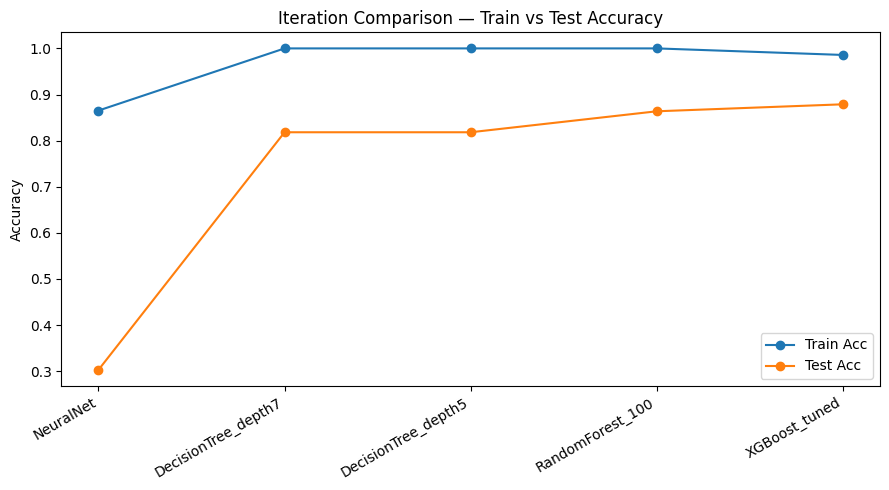

In [43]:
# --- 7) Figure 83 — Train vs Test Accuracy
plt.figure(figsize=(9,5))
order = tab8.sort_values('TestAcc')['Model'].tolist()
plt.plot(order, tab8.set_index('Model').loc[order,'TrainAcc'], marker='o', label='Train Acc')
plt.plot(order, tab8.set_index('Model').loc[order,'TestAcc'], marker='o', label='Test Acc')
plt.ylabel('Accuracy'); plt.title('Iteration Comparison — Train vs Test Accuracy')
plt.xticks(rotation=30, ha='right'); plt.legend(); plt.tight_layout()
fig83_path = os.path.join(CONFIG['FIG_DIR'], 'fig83_iter_train_test_acc.png')
plt.savefig(fig83_path, dpi=160, bbox_inches='tight'); plt.show()

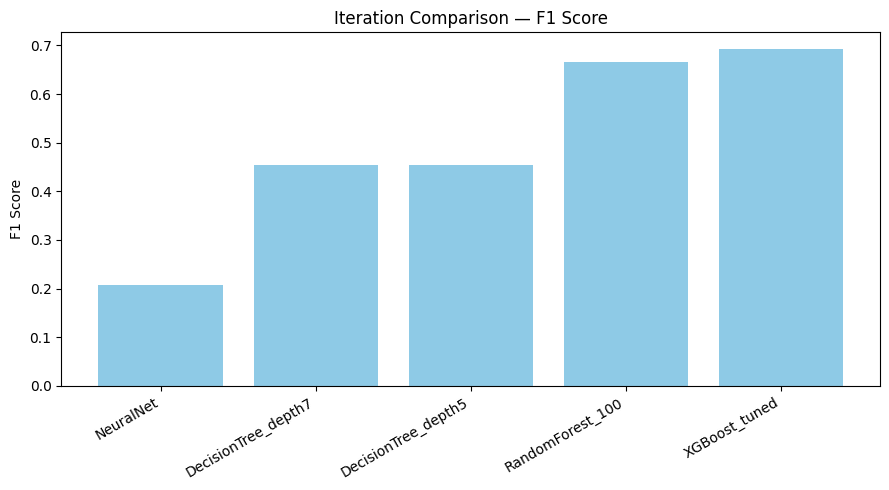

In [45]:
# --- 8) Figure 84 — F1 bar chart
plt.figure(figsize=(9,5))
plt.bar(order, tab8.set_index('Model').loc[order,'F1'], color='#8ecae6')
plt.ylabel('F1 Score'); plt.title('Iteration Comparison — F1 Score')
plt.xticks(rotation=30, ha='right'); plt.tight_layout()
fig84_path = os.path.join(CONFIG['FIG_DIR'], 'fig84_iter_f1.png')
plt.savefig(fig84_path, dpi=160, bbox_inches='tight'); plt.show()

**Notes**  
- Split is time-ordered (last 3 months = test).  
- Hotspot definition = top 10% districts by next-month count within each month.